In [1]:
# -*- coding: utf-8 -*-
"""content-based-model.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1hjGWwyxgPKXFiXrw8Doc-pMtQlFzMq2A
"""

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/data/MovieLens/'

ratings = pd.read_csv(path + 'ratings.dat', sep='::', engine='python',
                      names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

movies = pd.read_csv(path + 'movies.dat', sep='::', engine='python',
                     names=['MovieID', 'Title', 'Genres'], encoding='latin-1')

users = pd.read_csv(path + 'users.dat', sep='::', engine='python',
                    names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])



Mounted at /content/drive


In [2]:
# Display sample data
ratings.head()



,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
movies.head()



,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
users.head()



,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [5]:
# Check for missing values in each dataframe
print("Missing values in ratings:")
print(ratings.isnull().sum())

print("\nMissing values in movies:")
print(movies.isnull().sum())

print("\nMissing values in users:")
print(users.isnull().sum())



Missing values in ratings:
UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

Missing values in movies:
MovieID    0
Title      0
Genres     0
dtype: int64

Missing values in users:
UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64


In [6]:
# Genres column has multiple genres per movie separated by |
from sklearn.preprocessing import MultiLabelBinarizer

# Split genres
movies['Genres'] = movies['Genres'].apply(lambda x: x.split('|'))

# Binarize
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(movies['Genres']),
                             columns=mlb.classes_,
                             index=movies.index)

# Concatenate back to movies
movies = pd.concat([movies.drop('Genres', axis=1), genre_encoded], axis=1)

movies.head()



,MovieID,Title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Identify numerical columns in ratings dataframe
numerical_cols_ratings = ratings.select_dtypes(include=['int64', 'float64']).columns

print("Numerical columns in ratings dataframe:", numerical_cols_ratings)

# Apply IQR method to each numerical column in ratings dataframe
for col in numerical_cols_ratings:
    Q1 = ratings[col].quantile(0.25)
    Q3 = ratings[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ratings[(ratings[col] < lower_bound) | (ratings[col] > upper_bound)]

    print(f"\nOutliers in '{col}' column of ratings dataframe:")
    if outliers.empty:
        print("No outliers found.")
    else:
        print(outliers)

#Labelencoding

le_gender = LabelEncoder()
users['Gender'] = le_gender.fit_transform(users['Gender'])  # M=1, F=0

users.head()



Numerical columns in ratings dataframe: Index(['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype='object')

Outliers in 'UserID' column of ratings dataframe:
No outliers found.

Outliers in 'MovieID' column of ratings dataframe:
No outliers found.

Outliers in 'Rating' column of ratings dataframe:
         UserID  MovieID  Rating  Timestamp
148           2       21       1  978299839
180           2     3893       1  978299535
205           3     1261       1  978297663
249           4     3527       1  978294008
268           5     2916       1  978245645
...         ...      ...     ...        ...
1000171    6040     3388       1  956716407
1000177    6040     2751       1  956716438
1000185    6040     2794       1  956716438
1000187    6040     2003       1  956716294
1000204    6040     1091       1  956716541

[56174 rows x 4 columns]

Outliers in 'Timestamp' column of ratings dataframe:
         UserID  MovieID  Rating   Timestamp
2327         19      318       4   994556598
24

,UserID,Gender,Age,Occupation,Zip-code
0,1,0,1,10,48067
1,2,1,56,16,70072
2,3,1,25,15,55117
3,4,1,45,7,02460
4,5,1,25,20,55455


In [8]:
#Embedding on title column
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
title_embeddings = tfidf.fit_transform(movies['Title'])

"""#  Content-Based Filtering (TF-IDF using movie metadeta)"""

# TF-IDF Vectorization on Genres

tfidf_genres = TfidfVectorizer()
genre_embeddings = tfidf_genres.fit_transform(movies[mlb.classes_].astype(str))

# Compute Cosine Similarity

from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between two movies based on genre
# Let's pick the first two movies
movie1_genre_vector = genre_embeddings[0]
movie2_genre_vector = genre_embeddings[1]

# Reshape the vectors for cosine_similarity
movie1_genre_vector = movie1_genre_vector.reshape(1, -1)
movie2_genre_vector = movie2_genre_vector.reshape(1, -1)

cosine_sim = cosine_similarity(movie1_genre_vector, movie2_genre_vector)

print(f"Cosine Similarity between movie 1 and movie 2 (based on genre): {cosine_sim[0][0]}")


Cosine Similarity between movie 1 and movie 2 (based on genre): 0.0


In [9]:
# Create a mapping of movie titles to indices
movie_title_to_index = pd.Series(movies.index, index=movies['Title']).to_dict()
print("\nMapping of movie titles to indices:")
print(list(movie_title_to_index.items())[:5]) # Print first 5 items as an example


def get_recommendations(movie_title, cosine_sim_matrix, movies_df, title_to_index_map):
    """
    Generates movie recommendations based on cosine similarity.

    Args:
        movie_title (str): The title of the movie for which to get recommendations.
        cosine_sim_matrix (scipy.sparse.csr_matrix or np.ndarray): The cosine similarity matrix.
        movies_df (pd.DataFrame): The dataframe containing movie information.
        title_to_index_map (dict): A mapping from movie titles to their indices in the dataframe.

    Returns:
        pd.DataFrame: A dataframe containing the top 10 most similar movies (excluding the input movie).
                      Returns an empty DataFrame if the movie title is not found.
    """
    if movie_title not in title_to_index_map:
        print(f"Movie '{movie_title}' not found.")
        return pd.DataFrame()

    # Get the index of the movie that matches the title
    idx = title_to_index_map[movie_title]

    # Get the pairwise similarity scores with that movie
    # If using a sparse matrix, convert the row to a dense array for sorting
    if hasattr(cosine_sim_matrix, 'todense'):
        sim_scores = list(enumerate(cosine_sim_matrix[idx].todense().flatten()))
    else:
        sim_scores = list(enumerate(cosine_sim_matrix[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    # Skip the first score as it's the movie itself
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 recommended movies
    return movies_df['Title'].iloc[movie_indices]

# Example Usage (assuming you have a cosine similarity matrix like genre_embeddings or title_embeddings)
# You would typically calculate a combined similarity matrix for better results
# For demonstration, let's use the genre similarity embeddings
genre_cosine_sim_matrix = cosine_similarity(genre_embeddings)

print("\nRecommendations for 'Toy Story (1995)' based on genre:")
print(get_recommendations('Toy Story (1995)', genre_cosine_sim_matrix, movies, movie_title_to_index))

# You could also compute similarity based on title embeddings:
title_cosine_sim_matrix = cosine_similarity(title_embeddings)
print("\nRecommendations for 'Toy Story (1995)' based on title:")
print(get_recommendations('Toy Story (1995)', title_cosine_sim_matrix, movies, movie_title_to_index))

# Example usage:

# Scale numerical features in users dataframe
numerical_cols_users = users.select_dtypes(include=['int64', 'float64']).columns

# Exclude UserID as it's an identifier and Gender as it's already label encoded
cols_to_scale = numerical_cols_users.drop(['UserID', 'Gender'])

scaler = MinMaxScaler()
users[cols_to_scale] = scaler.fit_transform(users[cols_to_scale])

users.head()




Mapping of movie titles to indices:
[('Toy Story (1995)', 0), ('Jumanji (1995)', 1), ('Grumpier Old Men (1995)', 2), ('Waiting to Exhale (1995)', 3), ('Father of the Bride Part II (1995)', 4)]

Recommendations for 'Toy Story (1995)' based on genre:
1                         Jumanji (1995)
2                Grumpier Old Men (1995)
3               Waiting to Exhale (1995)
4     Father of the Bride Part II (1995)
5                            Heat (1995)
6                         Sabrina (1995)
7                    Tom and Huck (1995)
8                    Sudden Death (1995)
9                       GoldenEye (1995)
10        American President, The (1995)
Name: Title, dtype: object

Recommendations for 'Toy Story (1995)' based on title:
3045                       Toy Story 2 (1999)
2892                  Story of Us, The (1999)
2039                        L.A. Story (1991)
2205                    Lilian's Story (1995)
292         Pyromaniac's Love Story, A (1995)
26                        N

,UserID,Gender,Age,Occupation,Zip-code
0,1,0,0.000000,0.50,48067
1,2,1,1.000000,0.80,70072
2,3,1,0.436364,0.75,55117
3,4,1,0.800000,0.35,02460
4,5,1,0.436364,1.00,55455


In [10]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack

# Combine title and genre embeddings
combined_embeddings = hstack([title_embeddings, genre_encoded])
cosine_sim_matrix = cosine_similarity(combined_embeddings)

indices = pd.Series(movies.index, index=movies['Title']).drop_duplicates()

def get_recommendations(title, top_k=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_k+1]  # Exclude the movie itself

    movie_indices = [i[0] for i in sim_scores]
    return movies.iloc[movie_indices][['Title']]

def precision_at_k(user_id, k=10, threshold=4.0):
    user_data = ratings[ratings['UserID'] == user_id]
    user_movies = user_data['MovieID'].values
    user_rated_high = user_data[user_data['Rating'] >= threshold]['MovieID'].values

    relevant = 0
    total = 0

    for movie_id in user_movies:
        title = movies[movies['MovieID'] == movie_id]['Title'].values[0]
        if title not in indices:
            continue

        recs = get_recommendations(title, top_k=k)
        rec_ids = movies[movies['Title'].isin(recs['Title'])]['MovieID'].values

        relevant += len(set(rec_ids) & set(user_rated_high))
        total += k

    if total == 0:
        return 0.0
    return relevant / total

def evaluate_precision_at_k(k=10, threshold=4.0, num_users=100):
    sample_users = ratings['UserID'].unique()[:num_users]
    precisions = []

    for user_id in sample_users:
        p_at_k = precision_at_k(user_id, k=k, threshold=threshold)
        precisions.append(p_at_k)

    average_precision = np.mean(precisions)
    print(f"Average Precision@{k} for {num_users} users: {average_precision:.4f}")
    return precisions



Average Precision@1 for 50 users: 0.1276
Average Precision@3 for 50 users: 0.0988
Average Precision@5 for 50 users: 0.0899
Average Precision@10 for 50 users: 0.0805
Average Precision@15 for 50 users: 0.0744


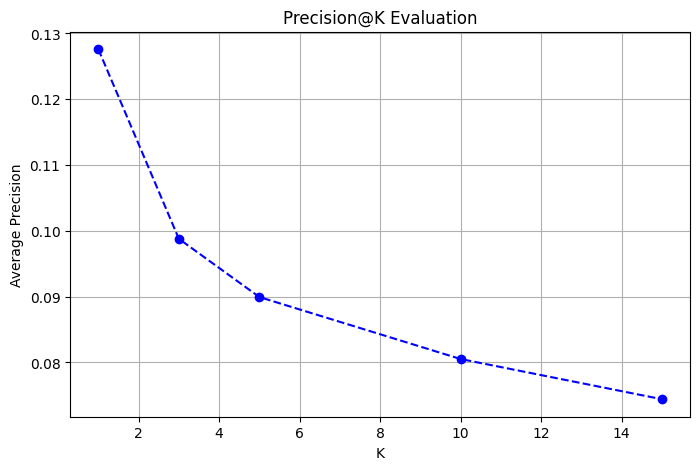

In [11]:
import matplotlib.pyplot as plt
import numpy as np

ks = [1, 3, 5, 10, 15]
avg_precisions = []

for k in ks:
    precisions = evaluate_precision_at_k(k=k, num_users=50)
    avg_precisions.append(np.mean(precisions))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(ks, avg_precisions, marker='o', linestyle='--', color='b')
plt.title('Precision@K Evaluation')
plt.xlabel('K')
plt.ylabel('Average Precision')
plt.grid(True)
plt.show()



In [12]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

def predict_rating(user_id, movie_id, k=10):
    if movie_id not in movies['MovieID'].values:
        return np.nan

    idx = movies[movies['MovieID'] == movie_id].index[0]
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:k+1]

    weighted_sum = 0
    sim_sum = 0

    for i, score in sim_scores:
        neighbor_id = movies.iloc[i]['MovieID']
        neighbor_rating = ratings[(ratings['UserID'] == user_id) & (ratings['MovieID'] == neighbor_id)]

        if not neighbor_rating.empty:
            weighted_sum += neighbor_rating['Rating'].values[0] * score
            sim_sum += score

    return weighted_sum / sim_sum if sim_sum != 0 else np.nan

# Evaluate on a sample of users
true_ratings = []
pred_ratings = []

sample_users = ratings['UserID'].unique()[:100]

for user in sample_users:
    user_data = ratings[ratings['UserID'] == user].sample(5)
    for _, row in user_data.iterrows():
        true_ratings.append(row['Rating'])
        pred = predict_rating(user, row['MovieID'])
        pred_ratings.append(pred)

# Drop NaNs
true_ratings = np.array(true_ratings)
pred_ratings = np.array(pred_ratings)
mask = ~np.isnan(pred_ratings)
true_ratings = true_ratings[mask]
pred_ratings = pred_ratings[mask]

# Compute RMSE and MAE
rmse = np.sqrt(mean_squared_error(true_ratings, pred_ratings))
mae = mean_absolute_error(true_ratings, pred_ratings)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 1.1339
MAE: 0.8197


In [17]:

import pickle

model_components = {
    'cosine_sim_matrix': cosine_sim_matrix,
    'movies_df_subset': movies[['MovieID', 'Title']], # Save only necessary columns
    'indices': indices,
    'ratings_df': ratings # You might want to subset this or just save the necessary info if it's too big
}


filename = 'content_based_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model_components, file)

print(f"Model components saved to {filename}")

# You can then download the file if needed
from google.colab import files
files.download(filename)


Model components saved to content_based_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>